# 🎉 Exploratory Data Analysis for Linkedin Job Posting 2023  🎉

Team-RYL: Lluka Stojollari, Renqing Cuomao, Yunlong Dong 

March 2024, Data Visualization, Milestone 1, EPFL

This notebook contains the code and analysis for the exploratory data analysis of the Linkedin Job Posting dataset for the year 2023. The goal of this analysis is to gain insights and understand the characteristics of the job postings in order to inform decision-making and strategy.

**Note**: In order to reproduce the results, please ensure that you have downloaded the data locally. Alternatively, you can run the notebook on the repository containing the data from this link:  https://github.com/LukaSt99/COM-480-Data/tree/main

## Imports and Libraries 🚨

Here, we import all the needed libraries. Make sure to install all the frameworks and libraries used below.

In [14]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import folium
from geopy.geocoders import Nominatim
import geopandas as gpd
import pandas as pd
from geopy.geocoders import Nominatim
import matplotlib.pyplot as plt
import pandas as pd
from scipy.stats import skewnorm

In [2]:
#pip install geopy
#pip install folium

Preprocessing phase: Containing basic preprocessing , merging and normalizing the data

In [21]:
# Read the CSV file into a pandas DataFrame
job_posting = pd.read_csv("Data/job_postings.csv") 
job_posting.head(2)  

,job_id,company_id,title,description,max_salary,med_salary,min_salary,pay_period,formatted_work_type,location,...,closed_time,formatted_experience_level,skills_desc,listed_time,posting_domain,sponsored,work_type,currency,compensation_type,scraped
0,3757940104,553718.0,Hearing Care Provider,Overview\n\nHearingLife is a national hearing ...,NaN,5250.0,NaN,MONTHLY,Full-time,"Little River, SC",...,NaN,Entry level,NaN,1.699090e+12,careers-demant.icims.com,0,FULL_TIME,USD,BASE_SALARY,1699138101
1,3757940025,2192142.0,Shipping & Receiving Associate 2nd shift (Beav...,Metalcraft of Mayville\nMetalcraft of Mayville...,NaN,NaN,NaN,NaN,Full-time,"Beaver Dam, WI",...,NaN,NaN,NaN,1.699080e+12,www.click2apply.net,0,FULL_TIME,NaN,NaN,1699085420


### Handling Missing Values in Salary Data

To address missing values in salary data, a multi-step approach is adopted. Initially, the dataset is grouped by job title and work type to calculate median salaries for similar positions. These medians are then used to impute missing values, ensuring accuracy and granularity in the imputation process. Additionally, to account for the distribution and statistics of the salary data, skew-normal distributions are fitted to observed salary data. Random values are generated from these distributions to fill missing entries, providing a comprehensive approach to handling missing values.


In [22]:
# Group by Title and Work Type and calculate median salaries
median_salaries = job_posting.groupby(['title', 'formatted_work_type']).agg({
    'max_salary': 'median',
    'med_salary': 'median',
    'min_salary': 'median'
}).reset_index()

# Function to impute missing values based on median salaries
def impute_missing_salaries(row, column_name):
    if pd.isnull(row[column_name]):
        return median_salaries[(median_salaries['title'] == row['title']) & 
                               (median_salaries['formatted_work_type'] == row['formatted_work_type'])][column_name].values[0]
    else:
        return row[column_name]

# Apply the imputation function to fill missing values in max_salary, med_salary, and min_salary
for column in ['max_salary', 'med_salary', 'min_salary']:
    job_posting[column] = job_posting.apply(impute_missing_salaries, axis=1, args=(column,))

most_common_pay_period = job_posting['pay_period'].mode()[0]
job_posting['pay_period'].fillna(most_common_pay_period, inplace=True)


C:\Users\User\AppData\Local\Temp\ipykernel_30912\1454912453.py:21: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  job_posting['pay_period'].fillna(most_common_pay_period, inplace=True)


In [23]:

# Fit probability distributions to observed salary data
max_salary_dist = skewnorm.fit(job_posting['max_salary'].dropna())
med_salary_dist = skewnorm.fit(job_posting['med_salary'].dropna())
min_salary_dist = skewnorm.fit(job_posting['min_salary'].dropna())

job_posting['max_salary'] = job_posting['max_salary'].fillna(pd.Series((np.floor(skewnorm.rvs(*max_salary_dist, size=len(job_posting)) * 1000)).astype(int) / 1000))
job_posting['med_salary'] = job_posting['med_salary'].fillna(pd.Series((np.floor(skewnorm.rvs(*med_salary_dist, size=len(job_posting)) * 1000)).astype(int) / 1000))
job_posting['min_salary'] = job_posting['min_salary'].fillna(pd.Series((np.floor(skewnorm.rvs(*min_salary_dist, size=len(job_posting)) * 1000)).astype(int) / 1000))

job_posting['med_salary'] = np.clip(job_posting['med_salary'], job_posting['min_salary'], job_posting['max_salary'])
job_posting['max_salary'] = np.maximum(job_posting['max_salary'], job_posting['min_salary'] + 0.001)

# Fill missing values in pay period with the most common value
most_common_pay_period = job_posting['pay_period'].mode()[0]
job_posting['pay_period'].fillna(most_common_pay_period, inplace=True)

C:\Users\User\AppData\Local\Temp\ipykernel_30912\4033610791.py:15: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  job_posting['pay_period'].fillna(most_common_pay_period, inplace=True)


In [ ]:
job_posting['max_salary'] = job_posting['max_salary'].apply(lambda x: int(round(x, -3)))
job_posting['med_salary'] = job_posting['med_salary'].apply(lambda x: int(round(x, -3)))
job_posting['min_salary'] = job_posting['min_salary'].apply(lambda x: int(round(x, -3)))

In [124]:
job_posting.head(2)

,job_id,company_id,title,description,max_salary,med_salary,min_salary,pay_period,formatted_work_type,location,...,closed_time,formatted_experience_level,skills_desc,listed_time,posting_domain,sponsored,work_type,currency,compensation_type,scraped
0,3749903318,3304.0,Marine Civil Field Engineer,Requisition ID: 272873\n\n Relocation Authoriz...,127000,115000,10000,YEARLY,Full-time,"Port Arthur, TX",...,NaN,Entry level,NaN,1.699070e+12,jobs.bechtel.com,0,FULL_TIME,NaN,NaN,1699135238
1,3756134301,60419691.0,Préposé au café - Banquets,Organization- Royal Palms Resort and Spa\n\nRé...,108000,17000,1000,YEARLY,Full-time,"Phoenix, AZ",...,NaN,Entry level,NaN,1.699060e+12,careers.hyatt.com,0,FULL_TIME,NaN,NaN,1699091122


### Visualizing Salary Statistics
This code generates a point plot visualizing median, maximum, and minimum salaries across different metrics (max_salary, med_salary, min_salary) from the dataset. Custom color palette and font styles are applied for improved visualization clarity.

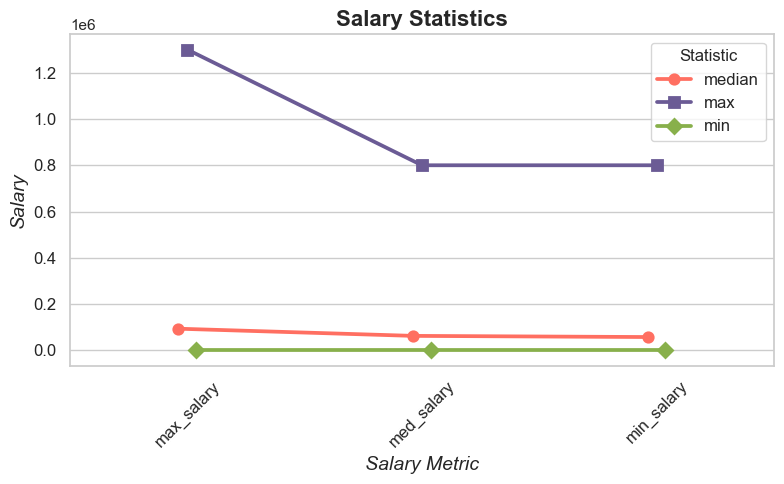

In [33]:
# Calculate the statistics for the entire dataset
statistics = job_posting[['max_salary', 'med_salary', 'min_salary']].agg(['median', 'max', 'min'])

# Transpose the statistics for easier plotting
statistics = statistics.T.reset_index()
melted_stats = pd.melt(statistics, id_vars=['index'], var_name='Statistic', value_name='Value')

custom_palette = ['#FF6F61', '#6B5B95', '#88B04B']
sns.set_style("whitegrid")
sns.set_context("notebook")

plt.figure(figsize=(8, 5))
sns.pointplot(data=melted_stats, x='index', y='Value', hue='Statistic', dodge=True, markers=["o", "s", "D"], palette=custom_palette)

# Adding labels and title with custom font styles
plt.xlabel('Salary Metric', fontstyle='italic', fontsize=14)
plt.ylabel('Salary', fontstyle='italic', fontsize=14)
plt.title('Salary Statistics', fontweight='bold', fontsize=16)

plt.legend(title='Statistic', fontsize=12)
plt.xticks(rotation=45, fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.show()

#### Mapping Most Frequent Job Postings
A scatter plot overlaid on a map, showcasing the top 150 locations with the highest frequency of job postings in North and South America. The red bubbles represent the locations, with their size indicating the frequency of job postings.

C:\Users\User\AppData\Local\Temp\ipykernel_30912\2994571571.py:20: FutureWarning:

The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.



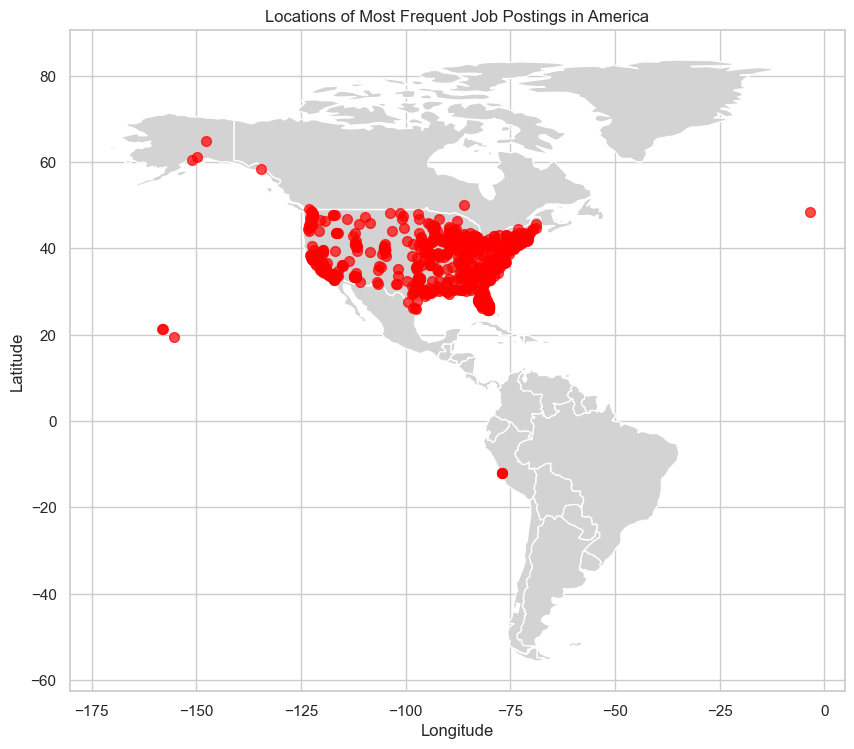

In [47]:

top_1000_locations = job_posting['location'].value_counts().head(1000)[1:]
geolocator = Nominatim(user_agent="job_map")

# Geocode the top 100 locations
geocoded_locations = {}
for location in top_1000_locations.index:
    try:
        location_info = geolocator.geocode(location)
        if location_info:
            geocoded_locations[location] = {
                'latitude': location_info.latitude,
                'longitude': location_info.longitude,
                'count': top_1000_locations[location]
            }
    except:
        pass

gdf = gpd.GeoDataFrame.from_dict(geocoded_locations, orient='index', columns=['latitude', 'longitude', 'count'])

world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
america = world[(world['continent'] == 'North America') | (world['continent'] == 'South America')]
fig, ax = plt.subplots(figsize=(10, 10))
america.plot(ax=ax, color='lightgrey')
gdf.plot(ax=ax, kind='scatter', x='longitude', y='latitude', s=50, color='red', alpha=0.7)
plt.title('Locations of Most Frequent Job Postings in America')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()


### Visualizing Top Posting Domains
A bar plot illustrating the top 10 posting domains with the highest number of job postings. Each bar represents a posting domain, colored according to a chosen palette, with the height indicating the number of jobs posted

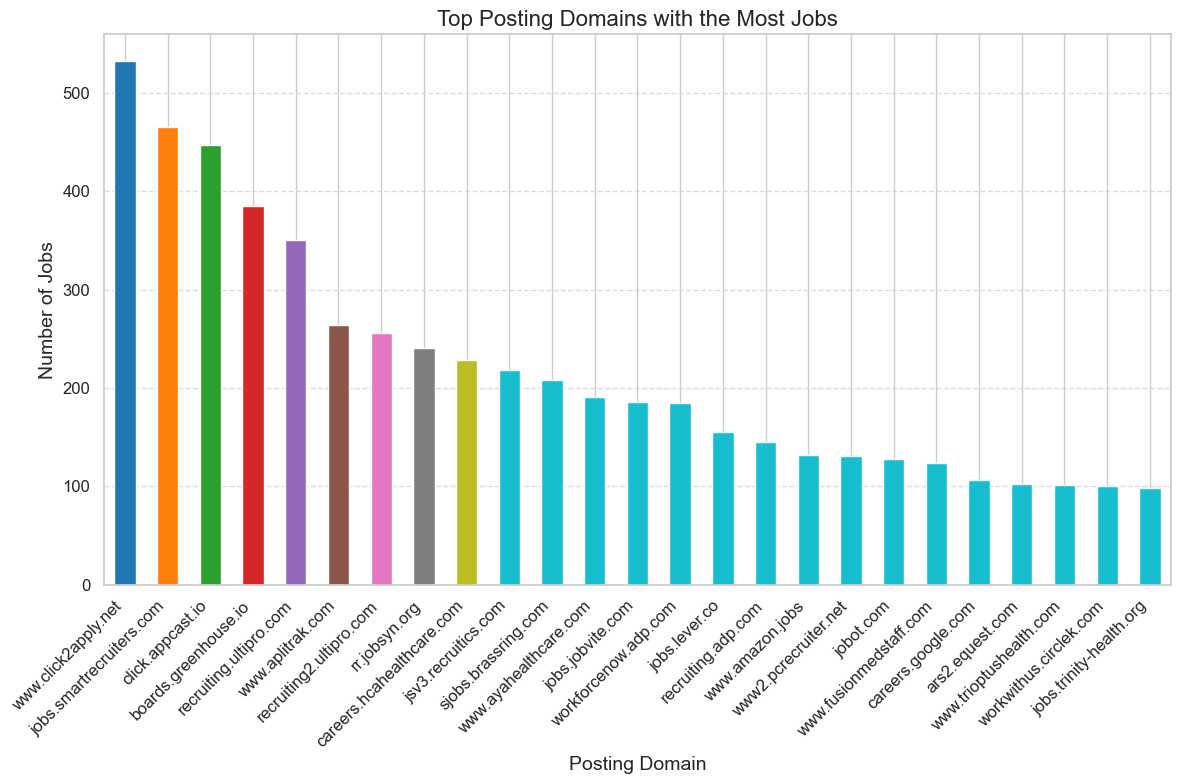

In [32]:

# Group by posting_domain and count the number of occurrences
posting_domain_counts = job_posting['posting_domain'].value_counts()
top_posting_domains = posting_domain_counts.head(25)  

# Plotting
plt.figure(figsize=(12, 8))
colors = plt.cm.tab10(range(len(top_posting_domains)))  
top_posting_domains.plot(kind='bar', color=colors)
plt.xlabel('Posting Domain', fontsize=14)
plt.ylabel('Number of Jobs', fontsize=14)
plt.title('Top Posting Domains with the Most Jobs', fontsize=16)
plt.xticks(rotation=45, ha='right', fontsize=12)
plt.yticks(fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)  
plt.tight_layout()
plt.show()


### Distribution of Job Postings by Experience Level
This visualization presents the distribution of job postings by experience level using a pie chart. Each slice of the pie represents a different experience level, with the percentage of job postings indicated.



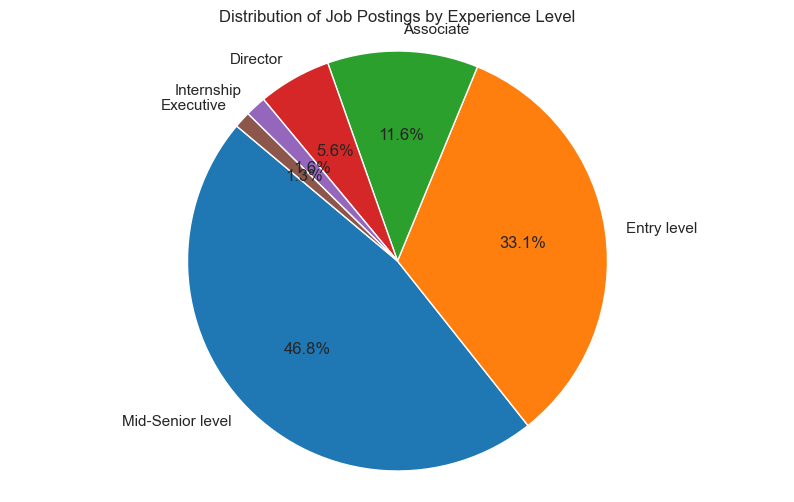

In [42]:
# Calculate the ratio of each experience level
experience_level_ratio = job_posting['formatted_experience_level'].value_counts(normalize=True)

plt.figure(figsize=(10, 6))
plt.pie(experience_level_ratio, labels=experience_level_ratio.index, autopct='%1.1f%%', startangle=140)
plt.title('Distribution of Job Postings by Experience Level')
plt.axis('equal') 
plt.show()


#### Company Overview
The companies DataFrame offers insights into various companies, encompassing diverse aspects such as their name, description, size and location. Additionally, it provides details about the company's address and URL. This dataset serves as a comprehensive resource for understanding the characteristics and geographical distribution of different companies.

In [45]:
#Company-related datasets
companies = pd.read_csv("Data/company_details/companies.csv")
companies.head(2)

,company_id,name,description,company_size,state,country,city,zip_code,address,url
0,1009,IBM,"At IBM, we do more than work. We create. We cr...",7.0,NY,US,"Armonk, New York",10504,International Business Machines Corp.,https://www.linkedin.com/company/ibm
1,1016,GE HealthCare,Every day millions of people feel the impact o...,7.0,0,US,Chicago,0,-,https://www.linkedin.com/company/gehealthcare


### Description:

This visualization illustrates job postings by company size and city location, focusing on a subset of specific company sizes and cities. Each point in the scatter plot represents a combination of company size and city, with the point size indicating the number of job postings. The subset selection enhances readability, allowing for a clearer understanding of job distribution within targeted areas.

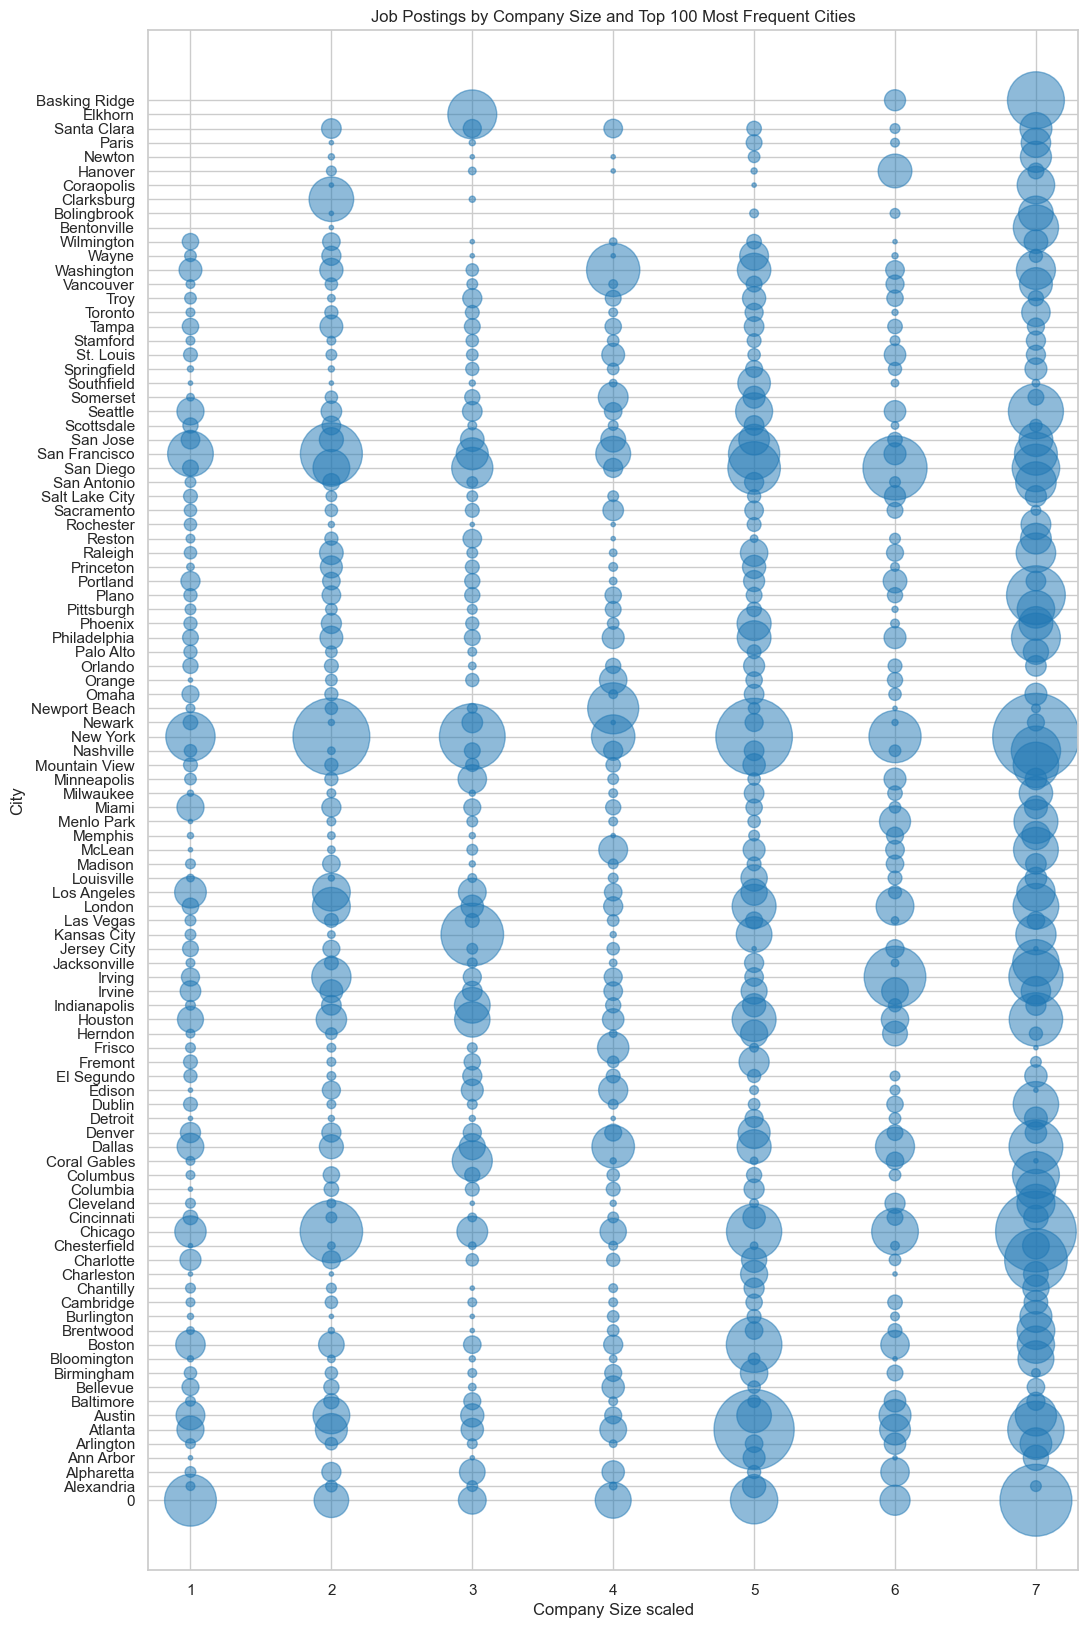

In [68]:

# Merge job_postings with companies on company_id to get company size and city
merged_data = pd.merge(job_posting, companies[['company_id', 'company_size', 'city']], on='company_id', how='left')
merged_data = merged_data.dropna(subset=['company_size', 'city'])

# Get the top 100 most frequent cities from the job postings
top_cities = merged_data['city'].value_counts().head(100).index.tolist()
subset_data = merged_data[merged_data['city'].isin(top_cities)]

# Group by company_size and city to count the number of job postings
grouped_data = subset_data.groupby(['company_size', 'city']).size().reset_index(name='count')

plt.figure(figsize=(12, 20))
plt.scatter(grouped_data['company_size'], grouped_data['city'], s=grouped_data['count']*10, alpha=0.5)
plt.xlabel('Company Size scaled')
plt.ylabel('City')
plt.title('Job Postings by Company Size and Top 100 Most Frequent Cities')
plt.grid(True)
plt.show()


### Explore Company Industries


In [69]:
company_industries = pd.read_csv("Data/company_details/company_industries.csv")
company_industries.head(2)

,company_id,industry
0,81149246,Higher Education
1,10033339,Information Technology & Services


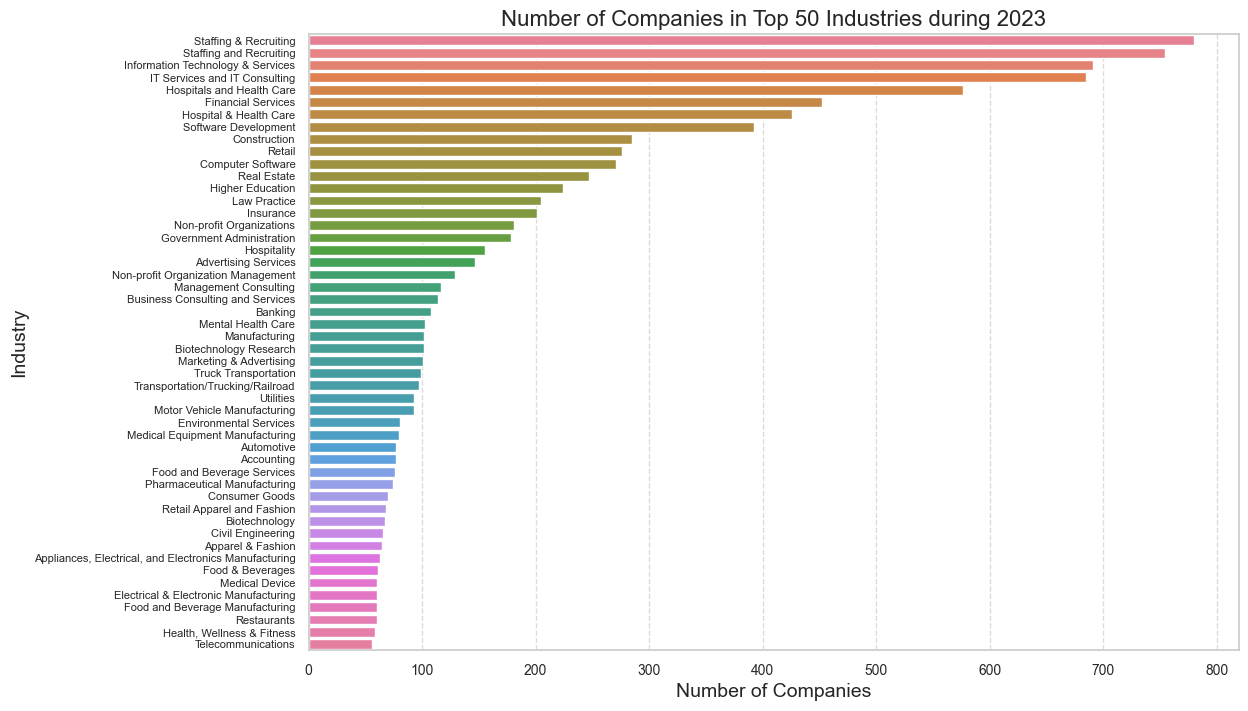

In [82]:

# Count the number of companies in each industry
industry_counts = company_industries['industry'].value_counts()[:50]

plt.figure(figsize=(12, 8))
sns.barplot(x=industry_counts.values, y=industry_counts.index, hue=industry_counts.index, dodge=False, legend=False)
plt.title('Number of Companies in Top 50 Industries during 2023', fontsize=16)
plt.xlabel('Number of Companies', fontsize=14)
plt.ylabel('Industry', fontsize=14)
plt.xticks(fontsize=10)
plt.yticks(fontsize=8)
plt.grid(axis='x', linestyle='--', alpha=0.7)

plt.show()


In [83]:
# group by company_id and create a list of industries (in order to get rid of duplicates)
company_industries = company_industries.groupby('company_id')['industry'].apply(lambda x: list(x)).reset_index()   
company_industries.head(3)

,company_id,industry
0,1009,"[Information Technology & Services, IT Service..."
1,1016,"[Hospital & Health Care, Hospitals and Health ..."
2,1021,"[Renewables & Environment, Renewable Energy Se..."



#### Company Specialties
This visualization depicts the distribution of companies across various industry specialties during the year 2023. Each bar represents a different industry specialty, with the length indicating the number of companies associated with that specialty.

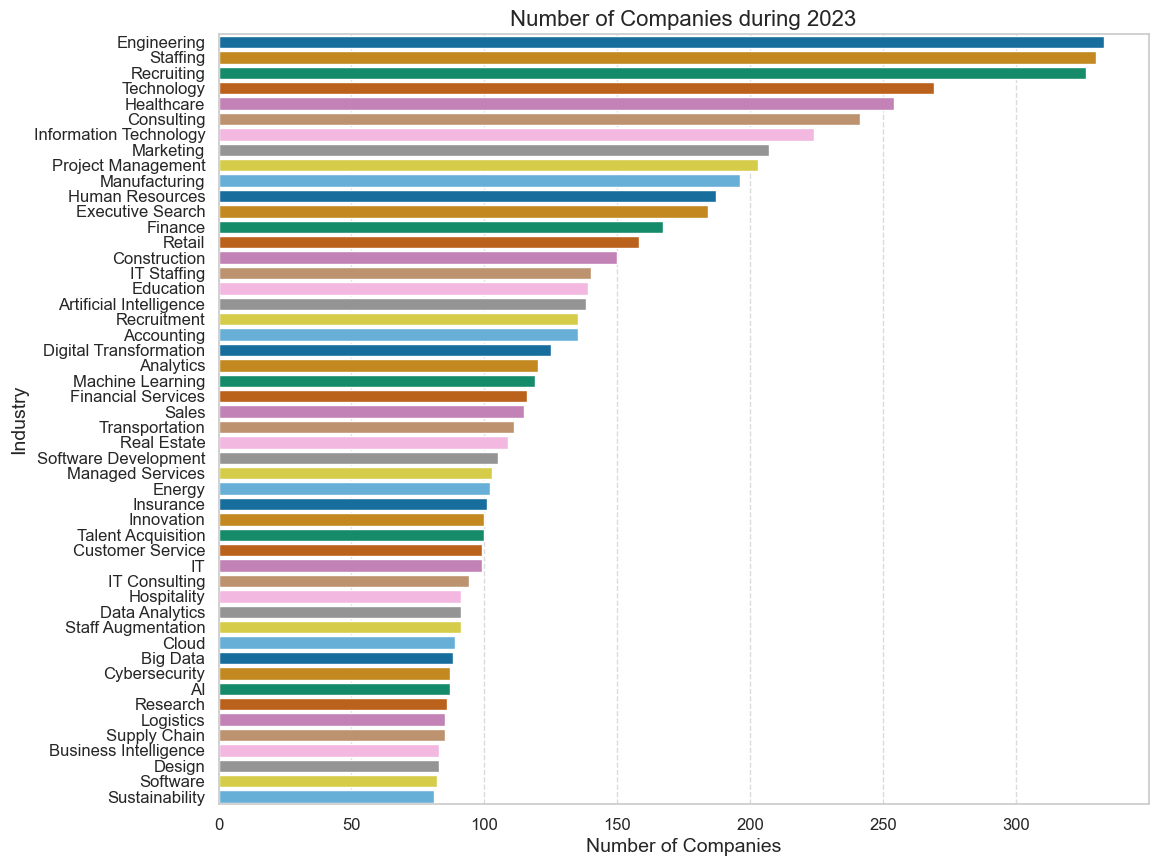

In [89]:
#Preprocess company_specialities
company_specialities = pd.read_csv("Data/company_details/company_specialities.csv")

company_specialities = company_specialities.groupby('company_id')['speciality'].apply(lambda x: list(x)).reset_index()

# Count the number of companies in each industry
industry_counts = company_specialities['speciality'].explode().value_counts()[:50]

plt.figure(figsize=(12, 10))
sns.barplot(x=industry_counts.values, y=industry_counts.index, hue=industry_counts.index, dodge=False, legend=False, palette='colorblind')
plt.title('Number of Companies during 2023', fontsize=16)
plt.xlabel('Number of Companies', fontsize=14)
plt.ylabel('Industry', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(axis='x', linestyle='--', alpha=0.7)

plt.show()



In [90]:
company_specialities = company_specialities.groupby('company_id')['speciality'].apply(lambda x: list(x)).reset_index()
company_specialities.head(3)

,company_id,speciality
0,1009,"[[Cloud, Mobile, Cognitive, Security, Research..."
1,1016,"[[Healthcare, Biotechnology]]"
2,1021,"[[Distributed Power, Gasification, Generators,..."


In [98]:
employee_counts = pd.read_csv("Data/company_details/employee_counts.csv")
#Since there are duplicates for each company_id, we will keep the latest observation 
employee_counts = employee_counts.sort_values('time_recorded', ascending=True).drop_duplicates('company_id')
employee_counts.head(3)

,company_id,employee_count,follower_count,time_recorded
0,81149246,6,91,1.692645e+09
1,10033339,3,187,1.692645e+09
2,6049228,20,82,1.692645e+09


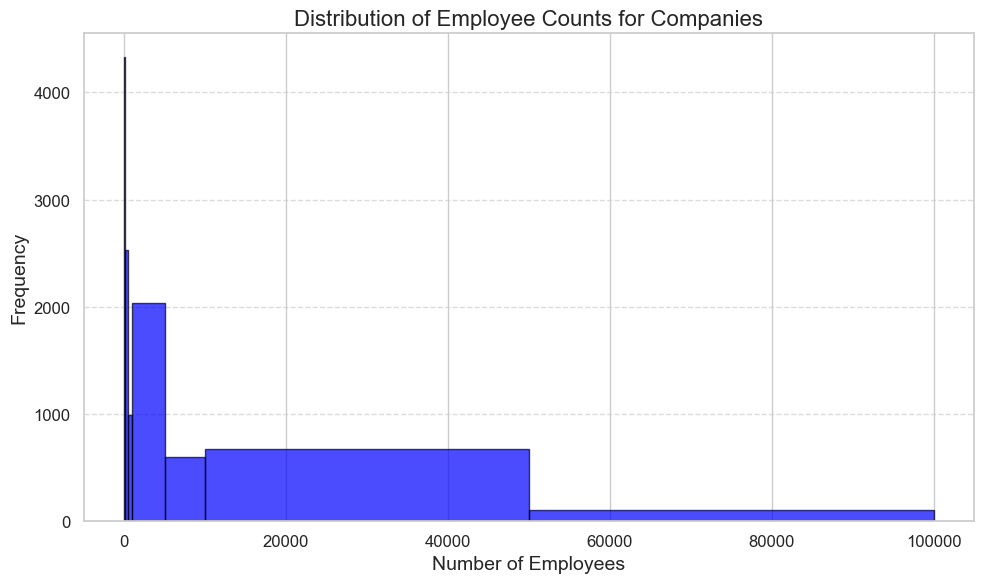

In [103]:
# Define the bins for employee count ranges
bins = [0, 100, 500, 1000, 5000, 10000, 50000, 100000]

plt.figure(figsize=(10, 6))
plt.hist(employee_counts['employee_count'], bins=bins, color='blue', alpha=0.7, edgecolor='black')

plt.title('Distribution of Employee Counts for Companies', fontsize=16)
plt.xlabel('Number of Employees', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()

plt.show()


##### Merge, filter, and preprocess the comprehensive set of company-related data from multiple datasets to facilitate comprehensive analysis.

In [104]:
#Merge the companies and company_industries datasets
companies = pd.merge(companies, company_industries, on='company_id', how='left') 
#Merge the companies and company_specialities datasets
companies = pd.merge(companies, company_specialities, on='company_id', how='left')
#Merge the companies and employee_counts datasets
companies = pd.merge(companies, employee_counts, on='company_id', how='left')
companies.head(5)

,company_id,name,description,company_size,state,country,city,zip_code,address,url,industry,speciality,employee_count,follower_count,time_recorded
0,1009,IBM,"At IBM, we do more than work. We create. We cr...",7.0,NY,US,"Armonk, New York",10504,International Business Machines Corp.,https://www.linkedin.com/company/ibm,"[Information Technology & Services, IT Service...","[[Cloud, Mobile, Cognitive, Security, Research...",316130.0,16114398.0,1.692851e+09
1,1016,GE HealthCare,Every day millions of people feel the impact o...,7.0,0,US,Chicago,0,-,https://www.linkedin.com/company/gehealthcare,"[Hospital & Health Care, Hospitals and Health ...","[[Healthcare, Biotechnology]]",53495.0,2060378.0,1.692853e+09
2,1021,GE Power,"GE Power, part of GE Vernova, is a world energ...",7.0,NY,US,Schenectady,12345,1 River Road,https://www.linkedin.com/company/gepower,"[Renewables & Environment, Renewable Energy Se...","[[Distributed Power, Gasification, Generators,...",26963.0,2340835.0,1.692866e+09
3,1025,Hewlett Packard Enterprise,Official LinkedIn of Hewlett Packard Enterpris...,7.0,Texas,US,Houston,77389,1701 E Mossy Oaks Rd Spring,https://www.linkedin.com/company/hewlett-packa...,"[Information Technology & Services, IT Service...",NaN,70995.0,3646359.0,1.692840e+09
4,1028,Oracle,We’re a cloud technology company that provides...,7.0,Texas,US,Austin,78741,2300 Oracle Way,https://www.linkedin.com/company/oracle,"[Information Technology & Services, IT Service...","[[enterprise, software, applications, database...",202019.0,9289332.0,1.692861e+09


### Import maps datasets

In [105]:
#Maps datasets
industries = pd.read_csv("Data/maps/industries.csv")
industries.head(3)

,industry_id,industry_name
0,1,Defense and Space Manufacturing
1,3,Computer Hardware Manufacturing
2,4,Software Development


In [106]:
#Maps datasets
skills = pd.read_csv("Data/maps/skills.csv")
skills.head(3)

,skill_abr,skill_name
0,PRCH,Purchasing
1,SUPL,Supply Chain
2,PR,Public Relations


#### Job-related datasets

In [107]:
#Job-related datasets
benefits = pd.read_csv("Data/job_details/benefits.csv")
# group by job_id and create a list of benefits (in order to get rid of duplicates)
benefits = benefits.groupby('job_id')['type'].apply(lambda x: list(x)).reset_index()
benefits.head(3)

,job_id,type
0,3958427,[Medical insurance]
1,85008768,"[Medical insurance, Vision insurance, Dental i..."
2,133114754,"[Medical insurance, 401(k), Vision insurance]"


In [108]:

job_industries = pd.read_csv("Data/job_details/job_industries.csv")
#Merge job_industries and industries datasets
job_industries = pd.merge(job_industries, industries, on='industry_id', how='left')
# group by job_id and create a list of industries (in order to get rid of duplicates)

job_industries = job_industries.groupby('job_id')['industry_name'].apply(lambda x: list(x)).reset_index()
job_industries.head(3)

,job_id,industry_name
0,3958427,[Personal Care Product Manufacturing]
1,85008768,[Insurance]
2,102339515,[Consumer Services]


In [109]:
job_skills = pd.read_csv("Data/job_details/job_skills.csv")
#Merge job_skills and skills datasets
job_skills = pd.merge(job_skills, skills, on='skill_abr', how='left')
job_skills = job_skills.groupby('job_id')['skill_name'].apply(lambda x: list(x)).reset_index()
job_skills.head(3)

,job_id,skill_name
0,3958427,"[Design, Art/Creative, Information Technology]"
1,85008768,"[Sales, Business Development]"
2,102339515,"[Business Development, Sales]"


In [123]:
salaries = pd.read_csv("Data/job_details/salaries.csv")

### Performing Salary Analysis by Skill

To analyze the distribution of salaries attributed to different skills, we first merge the salary and job skills datasets using the `job_id` column as the key. This allows us to link each salary entry to its corresponding skill. Then, we group the data by skill name and calculate the total median salary for each skill. Finally, we visualize the proportion of total salaries associated with each skill using a bar plot, providing insights into the contribution of various skills to overall salary distribution.

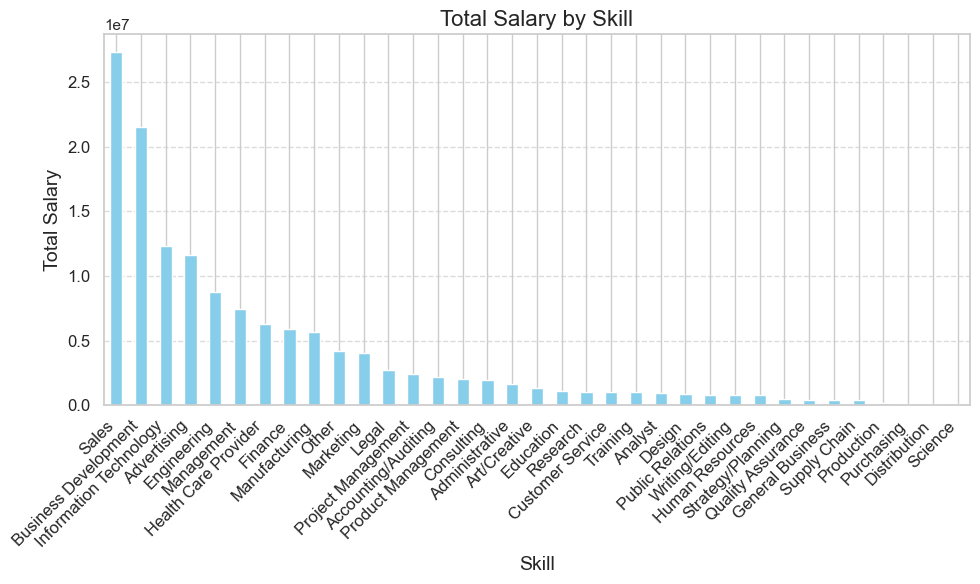

In [122]:
merged_data = pd.merge(salaries, job_skills.explode('skill_name'), on='job_id', how='inner')

skill_salary = merged_data.groupby('skill_name')['med_salary'].sum().sort_values(ascending=False)

plt.figure(figsize=(10, 6))
skill_salary.plot(kind='bar', color='skyblue')
plt.title('Total Salary by Skill', fontsize=16)
plt.xlabel('Skill', fontsize=14)
plt.ylabel('Total Salary', fontsize=14)
plt.xticks(rotation=45, ha='right', fontsize=12)
plt.yticks(fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()

plt.show()
